# Predicting S&P500 index with a simple linear regression model

In this project, we will develop a simple linear regression model for predicting the trading day closure prices of S&P500 index 

## The dataset

We will use historical daily record of S&P500 Index price from 1950 to 2015.

The columns of the dataset are:

- Date -- The date of the record.
- Open -- The opening price of the day (when trading starts).
- High -- The highest trade price during the day.
- Low -- The lowest trade price during the day.
- Close -- The closing price for the day (when trading is finished).
- Volume -- The number of shares traded.
- Adj Close -- The daily closing price, adjusted retroactively to include any corporate actions. Read more here.


Let's read the data.

In [1]:
import pandas as pd

df = pd.read_csv("sphist.csv", parse_dates = ["Date"])
df = df.sort_values(by = "Date").reset_index(drop = True)
df.describe()

,Open,High,Low,Close,Volume,Adj Close
count,16590.000000,16590.000000,16590.000000,16590.000000,1.659000e+04,16590.000000
mean,482.570941,485.624237,479.367501,482.692491,7.940099e+08,482.692491
std,554.889186,558.186049,551.367625,555.007904,1.456582e+09,555.007904
min,16.660000,16.660000,16.660000,16.660000,6.800000e+05,16.660000
25%,83.860001,84.594997,83.139997,83.860001,7.610000e+06,83.860001
50%,144.049995,145.294998,143.105004,144.264999,7.170500e+07,144.264999
75%,950.722488,956.665024,941.969986,950.797500,7.866750e+08,950.797500
max,2130.360107,2134.719971,2126.060059,2130.820068,1.145623e+10,2130.820068


We will be predicting the closure valuation of S&P500. Let's plot it on the timeline.

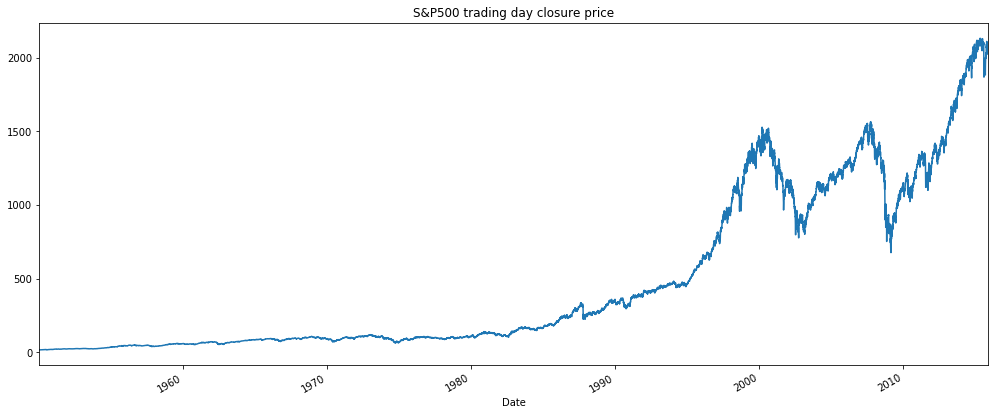

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
df.set_index('Date')['Close'].plot(title = 'S&P500 trading day closure price',
                                   figsize = (17,7))
plt.show()

## Addition of datetime features as predictors

We see that there are some seasonal cycles of rises and falls. Let's add some rolling averages.

In [3]:
from datetime import datetime, timedelta

df["av_5"] = df["Close"].rolling(window = 5).mean().shift(1)
df["av_30"] = df["Close"].rolling(window = 30).mean().shift(1)
df["av_365"] = df["Close"].rolling(window = 365).mean()
df["av_5 / av_365"] = df["av_5"] / df["av_365"]
df["std_5"] = df["Close"].rolling(window = 5).std().shift(1)
df["std_30"] = df["Close"].rolling(window = 30).std().shift(1)
df["std_365"] = df["Close"].rolling(window = 365).std().shift(1)
df["std_5 / std_365"] = df["std_5"] / df["std_365"]

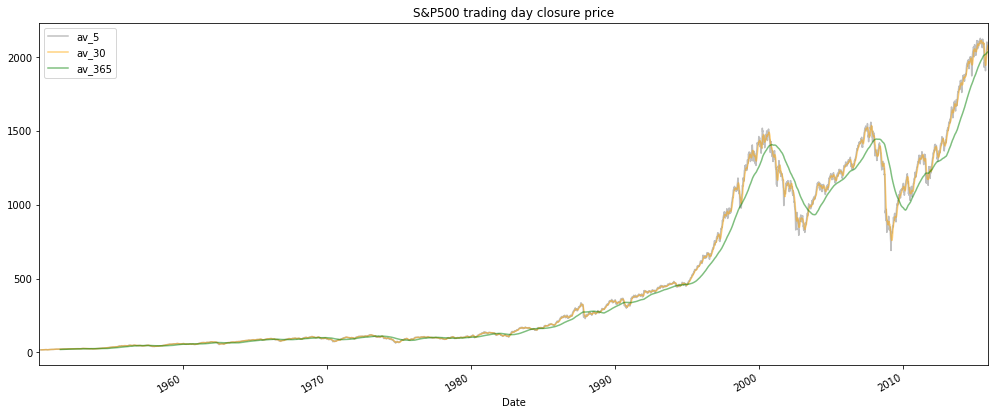

In [4]:
df.set_index('Date')[["av_5","av_30","av_365"]].plot(title = 'S&P500 trading day closure price',
                                   figsize = (17,7), alpha = 0.5, color = ['grey', 'orange', 'green'])
plt.show()

Let's drop null values and convert datetime categories to dummy variables.

In [5]:
df = df.dropna(axis = 0)
dummy_weekdays = pd.get_dummies(df["Date"].dt.weekday, prefix = "wd")
dummy_weekdays_cols = dummy_weekdays.columns
dummy_months = pd.get_dummies(df["Date"].dt.month, prefix = "mo")
dummy_months_cols = dummy_months.columns

df = pd.concat([df,dummy_weekdays,dummy_months], axis = 1)

Let's select the feats, which we'll use for prediction and the target variable.

In [6]:
feats = ["av_5","av_30", "av_5 / av_365",
         "std_5","std_5 / std_365",
         'wd_0', 'wd_1', 'wd_2',
         'wd_3', 'wd_4','mo_1', 'mo_2', 'mo_3', 'mo_4', 'mo_5', 'mo_6', 'mo_7', 'mo_8', 'mo_9',
       'mo_10', 'mo_11', 'mo_12']
target = "Close"

## Linear regression model

As we will be predicting closure prices for the next day, we will need to implement moving train-test sets selection: train should contain all the values before the prediction day, and test - only the value for prediction day. Let's program such model.

In [7]:
split_date = datetime(year = 2013, month = 1, day = 1)

first_prediction_ix = df[df["Date"] >= split_date].index[0]
last_prediction_ix = df.index[-1]

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error

predictions = []

for i in range(first_prediction_ix, last_prediction_ix+1):
    train = df.loc[:i-1]
    test = df.loc[i]
    
    m = LinearRegression()
    m.fit(train[feats], train[target])
    p = m.predict(test[feats].values.reshape(1, -1))
    
    predictions.append(p)

Let's calculate the error of our predictions

In [8]:
import numpy as np
def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mae = mean_absolute_error(df.loc[first_prediction_ix:, target], predictions)
mape = mape(df.loc[first_prediction_ix:, target].values, predictions)
print("MAE for predictions: {:.2f}".format(mae))
print("MAPE for predictions: {:.2f}".format(mape))

MAE for predictions: 16.07
MAPE for predictions: 12.03


The errors are actually not that low. The model could be optimized further. But let's finish with that and plot the results.

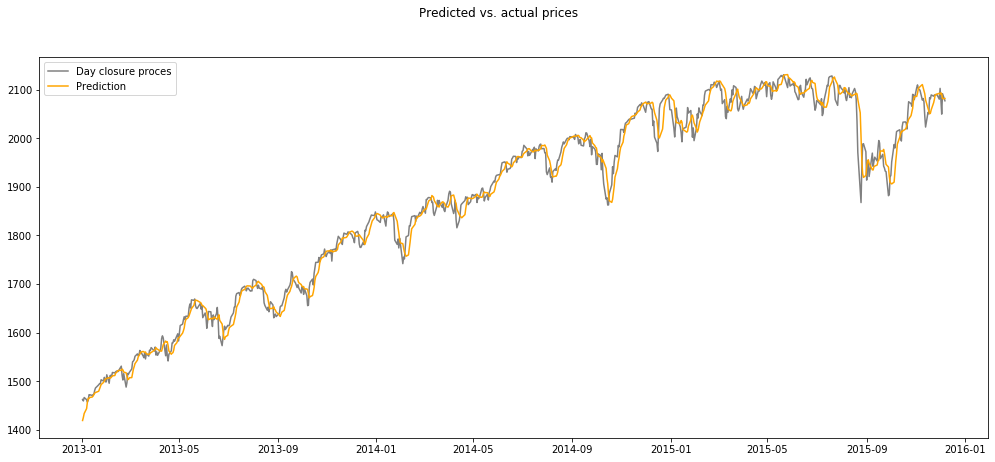

In [9]:
actuals = df.loc[first_prediction_ix:].set_index('Date')[target]
predictions
fig,ax = plt.subplots(figsize = (17,7))
ax.plot(actuals.index, actuals, c = "grey", label = 'Day closure proces')
ax.plot(actuals.index, predictions, c = "orange", label = 'Prediction')
plt.legend()
plt.suptitle('Predicted vs. actual prices')
plt.show()

## Results

We created a simple linear regression model to predict the trading day clusure prices of S&P500 index for the next day. We see that the error is relatively high, so the model should be optimized further. However, it can be used to predict direction of the change - from the predictions it is easy to get an array with values 'up' and 'down' and check how accurately it matches the ups and downs of the actual values.

A few suggestions for the model improvement:

1. We can fit our model better by including the calculation of recent trend for stock prices and applying it to trend-corrected predictions.
2. The model can be combined with random forest algorythm as it can produce better results for seasonal fluctuations without the need to find the actual correlations or seasonality coefficients.
3. Addition of extra data on external events, like info if there was a holiday before the day, some event labels (e.g. political events, natural disasters etc).